# Machine Learning with Python

The aim of this lab is to implement a complete ML project in python. We will go through the steps of data exploration, cleaning and transformation followed by model training and selection.

The lab consists of two parts. The first part is an interactive tutorial adapted from [Aurélien Géron's excellent ML book](https://github.com/ageron/handson-ml2) with some modifications to make it a classification tutorial instead of a regression one. We will learn to classify neighborhoods by median house value. The tutorial will contains conceptual questions as well as fill-in code that we'll give you a few minutes to write.

In the second part of this lab, you will  pick a dataset of your own choosing and go through the steps mentioned above. You should try at least 3 different classes of models, and one of them should be an `xgboost` classifier or regressor. We recommend that you pick a dataset from [Kaggle](https://www.kaggle.com/). We will be very flexible in grading this lab; we just need to see that you've taken the right steps. You should submit your notebook to gradescope. Submission instructions will be given on Piazza.

## Setup
Run the following code to install libraries and download required files.

In [26]:
import sys
assert sys.version_info >= (3, 9) # You might later get errors if you have a lower version.

# Install necessary libraries
!pip install sklearn matplotlib numpy pandas xgboost

# Do all necessary imports
import sklearn
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [27]:
# Download necessary files
import tarfile
import urllib.request

def perform_downloads():
    # Download data file
    root_url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
    housing_url = f"{root_url}datasets/housing/housing.tgz"
    tgz_path = "housing.tgz"
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path="./")
    housing_tgz.close()
    

def to_classification():
    # Original dataset was for a regression tasks.
    # Transform it to classification task.
    classes = ['LOW', 'MEDIUM', 'HIGH']
    housing = pd.read_csv('housing.csv')
    housing["house_value_class"] = pd.cut(housing["median_house_value"], bins=[0.0, 200000, 400000, np.inf], labels=classes)
    housing.drop('median_house_value', axis=1, inplace=True)
    housing.to_csv("housing_classification.csv", index=False)

    
    
perform_downloads()
to_classification()

## Preliminary
Before we begin, we  split our data into a training and a testing set. All our learning will be done on the training set. The testing set is going to used only once after training.**Q: Why is a good idea?**

You could manually implement the splitting logic, but Scikit-Learn has builtin functions that do this for us. There are many splitting methodologies, but the simplest one that works well for us is as follows

In [28]:
# Import splitting function
from sklearn.model_selection import train_test_split

# Read data
data = pd.read_csv("housing_classification.csv")

# Split data. 80% is used as training; 20% as testing. The data will be randomly split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=37)

print(f"data size={len(data)}; training size={len(train_set)}; testing size={len(test_set)}")

data size=20640; training size=16512; testing size=4128


## Data Exploration

In [29]:
# Read data, and take look at the attributes
housing = train_set # Rename for convenience
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,house_value_class
9694,-121.63,36.68,24.0,2591.0,739.0,3243.0,702.0,2.1766,<1H OCEAN,LOW
18859,-122.09,41.32,52.0,4019.0,824.0,1728.0,706.0,2.2462,INLAND,LOW
11074,-117.86,33.80,34.0,1793.0,480.0,1722.0,441.0,2.8235,<1H OCEAN,LOW
10858,-117.86,33.71,36.0,191.0,42.0,208.0,37.0,3.3750,<1H OCEAN,LOW
16462,-121.27,38.11,11.0,3163.0,794.0,2106.0,762.0,2.4482,INLAND,LOW


Each row contains housing data aggregated by *block group*, which is how the US officially reports housing data. Our goal is to predict the housing value class (low, medium or high) given information about a block. Let's take a look at the columns within the dataframe.

In [41]:
# Info gives a quick summary
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 9694 to 1935
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16345 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
 9   house_value_class   16512 non-null  object 
dtypes: float64(8), object(2)
memory usage: 1.4+ MB


First, note that the `total_bedrooms` columns contains missing values.  
**Q: What techniques can we use to handle them?** 

---

We also note that only the target class `house_value_class` and `ocean_proximity` are categorical. In the following code, find the distinct values of `ocean_proximity`.

In [53]:
# TODO: Distinct valus of house_value_class
print(housing.house_value_class.unique())

# TODO: Distinct values of ocean_proximity.
print(housing.ocean_proximity.unique())

['LOW' 'MEDIUM' 'HIGH']
['<1H OCEAN' 'INLAND' 'NEAR BAY' 'NEAR OCEAN' 'ISLAND']


**Q: What's the standard way of dealing with categorical features in ML algorithms?**

----

As for the numerical attributes, we can quickly summarize their distribution as follows:

In [32]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16345.000000,16512.000000,16512.000000,16512.000000
mean,-119.568522,35.626854,28.627786,2644.478622,539.302845,1428.389777,500.421693,3.877276
std,2.008938,2.137589,12.589142,2187.314665,422.062383,1131.002342,382.423411,1.908253
min,-124.350000,32.540000,1.000000,8.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1445.000000,295.000000,787.000000,279.000000,2.566350
50%,-118.490000,34.250000,29.000000,2128.000000,435.000000,1167.000000,410.000000,3.541700
75%,-118.000000,37.710000,37.000000,3160.000000,648.000000,1728.000000,607.000000,4.750000
max,-114.310000,41.950000,52.000000,37937.000000,5471.000000,35682.000000,5189.000000,15.000100


We see that some columns (e.g., `longititude` vs `population`) have very different ranges of values.  
**Q: What's the standard way to deal with such differences in numerical data distributions?**

----

While these numbers are informative, plots are usually a lot more intuitive. Using [pandas.DataFrame.hist](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html), show a histogram for all the numerical columns.  
**Q: Briefly describe what stands out most to you?**

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>, <AxesSubplot:>]],
      dtype=object)

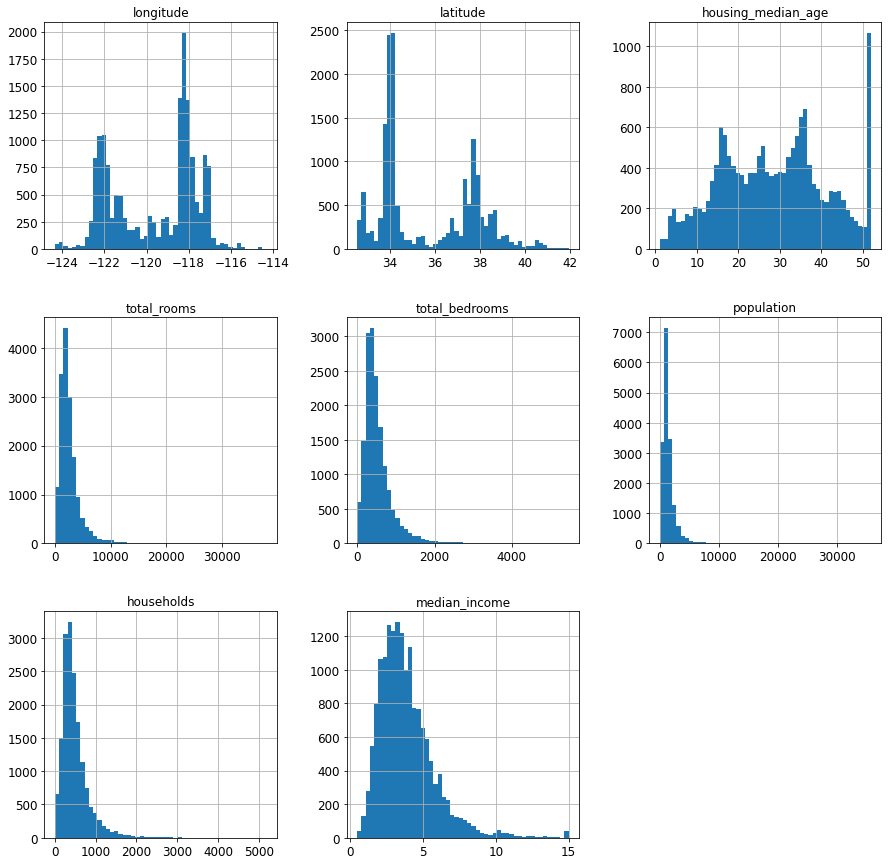

In [54]:
# TODO: Plot histograms (< 2min)
# Hint: Set figure size to (15, 15), and the number of bins to 50 for good formatting.
housing.hist(bins=50, figsize=(15,15))

It's also possible to visualize multiple attributes together. Using [pandas.DataFrame.plot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html), plot the relationship between total number of rooms and population. 

**Q: What do you notice?**

<AxesSubplot:xlabel='population', ylabel='total_rooms'>

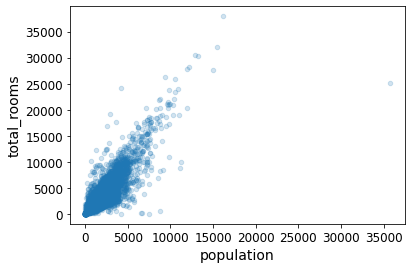

In [55]:
# TODO: plot population vs total_rooms
# Hint: Use a scatter plot.
housing.plot(kind="scatter", x="population", y="total_rooms", alpha=0.2)

Take a look at the following code.  

**Q: What pattern does the following code show?** Hint: [Look at this map.](https://www.google.com/maps/place/California/@36.4998513,-121.7064629,6.55z/data=!4m5!3m4!1s0x808fb9fe5f285e3d:0x8b5109a227086f55!8m2!3d36.778261!4d-119.4179324)

In [35]:
# TODO by TAs.
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, s=housing["population"]/100, label="population", figsize=(10,7))

We are now done with data exploration. We know what the data looks like, and what preparation we need to do before moving on to training.

## Data Preparation

In [36]:
# First separate features from target variables.
features = housing.drop("house_value_class", axis=1)
target = housing["house_value_class"]

We need the following transformation to make our data work with ML algorithms:
1. One hot encoding of the categorical features. 
2. Median imputation on numerical features.
3. Standardize numerical features.
4. Encode class labels into ordinals (0, 1, 2, ...). This is what the ML libraries we'll use expect.

`sklearn` has builtin functions for all of these. It also has convenience functions to put them all together.

----

One hot encoding works as follows.

In [37]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder

# Get columns to transform.
categorical_col_names = ['ocean_proximity'] # stored as a separate variable for later.
categorical = features[categorical_col_names]

# Do one hot encoding.
encoder = OneHotEncoder()
categorical_one_hot = encoder.fit_transform(categorical)
categorical_one_hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

As for imputation, `sklearn` has a [variety of implementations](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute) (corresponding to the techniques we described in class). We will stick to simple median imputation, but feel free to try something different in your custom project.

In [38]:
from sklearn.impute import SimpleImputer

# Get columns to transform.
numerical_col_names = [c for c in features.columns if c != 'ocean_proximity'] # stored as a separate variable for later.
numerical = features[numerical_col_names]

# Print missing count
print("Num missing before imputation:", np.count_nonzero(np.isnan(numerical)))

# Do transformation.
imputer = SimpleImputer(strategy="median")
imputed_numerical = imputer.fit_transform(numerical)

# Print missing count. Should be 0.
print("Num missing after imputation:", np.count_nonzero(np.isnan(imputed_numerical)))

Num missing before imputation: 167
Num missing before imputation: 0


Take a look at the documentation for [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and use it to normalize numerical columns in `imputed_numerical`.

In [39]:
# TODO: Do scaling (~2 mins)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(imputed_numerical)
numerical_scaled

`sklearn` has a simple API to chain all of these transformation together. Take a look at the documentation for [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and [sklearn.compose.ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Categorical Transformations
categorical_pipeline = Pipeline([
    ("one_hot_encoder", OneHotEncoder()),
])

# Numerical Transformations
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


# Full transformation
feature_transformer = ColumnTransformer([
    # Categorical
    ("categorical", categorical_pipeline, categorical_col_names),
    # Numerical
    ("numerical", numerical_pipeline, numerical_col_names),
])

features_prepped = feature_transformer.fit_transform(features)
pd.DataFrame(features_prepped)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,0.0,0.0,0.0,0.0,-1.026184,0.492694,-0.367613,-0.024450,0.477936,1.604475,0.527124,-0.891248
1,0.0,1.0,0.0,0.0,0.0,-1.255168,2.663430,1.856594,0.628425,0.680298,0.264915,0.537584,-0.854774
2,1.0,0.0,0.0,0.0,0.0,0.850486,-0.854659,0.426747,-0.389292,-0.138673,0.259610,-0.155387,-0.552237
3,1.0,0.0,0.0,0.0,0.0,0.850486,-0.896763,0.585619,-1.121719,-1.181432,-1.079066,-1.211839,-0.263220
4,0.0,1.0,0.0,0.0,0.0,-0.846980,1.161692,-1.400280,0.237066,0.608876,0.599142,0.684023,-0.748915
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.0,1.0,0.0,0.0,0.0,1.104359,-0.779806,-0.288177,-0.113603,-0.529112,-0.422107,-0.487489,2.286572
16508,1.0,0.0,0.0,0.0,0.0,0.671281,-0.695596,1.856594,-0.574456,-0.636245,-0.613094,-0.683613,-0.071730
16509,0.0,1.0,0.0,0.0,0.0,-1.140676,0.969882,-1.241408,3.189634,1.918277,2.617766,2.328846,1.470198
16510,0.0,1.0,0.0,0.0,0.0,0.890309,-0.489751,-1.797459,3.483153,3.156256,4.186334,3.348689,0.001585


Finally, we need to encode the label (LOW=i, MEDIUM=j, HIGH=k) to satisfy `sklearn`.

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

target_prepped = label_encoder.fit_transform(target)

pd.Series(target_prepped).unique()

array([1, 2, 0])

The data is now ready for ML modeling.

## Training and Validation
We'll now have to train and validate a few models to find the best performing one.
We start with the simple kind of model: linear classifier. We will then give a few minutes to try out gradient boosted trees.

Training a model is simple with `sklearn`.

In [18]:
from sklearn.linear_model import SGDClassifier

# Train model
lin_sgd = SGDClassifier(loss='hinge')

lin_sgd.fit(features_prepped, target_prepped)

SGDClassifier()

Performing predictions is equally easy.

In [19]:
# Get some random input
sample = housing.sample(n=10, random_state=1)
# Tranform input
sample_prepped = feature_transformer.transform(sample)
# Make prediction
prediction = lin_sgd.predict(sample_prepped)
# Decode prediction
label_encoder.inverse_transform(prediction)

array(['MEDIUM', 'MEDIUM', 'LOW', 'LOW', 'MEDIUM', 'LOW', 'LOW', 'MEDIUM',
       'MEDIUM', 'MEDIUM'], dtype=object)

Let's validate the efficacy of the model. `sklearn` provides builtin cross-validation. ****

In [20]:
from sklearn.model_selection import cross_val_score, KFold

# Do cross validation
# The cv parameter is the number of cross-validation splits.
lin_sgd = SGDClassifier(loss='hinge')
kfold = KFold(n_splits=10, shuffle=True, random_state=37)
scores = cross_val_score(lin_sgd, features_prepped, target_prepped, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))

Accuracy: 76.65% (1.27%)


We get a validation accuracy of ~$76\%$. This may or may not be ok depending on your application. Let's try `xgboost.XGBClassifier` and see if it does better.

In [25]:
from xgboost import XGBClassifier

# You'll need at least these  flags 
xgb_cls = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

# TODO: Add fitting and validation. Validation can be somewhat slow.
kfold = KFold(n_splits=10, shuffle=True, random_state=37)
scores = cross_val_score(xgb_cls, features_prepped, target_prepped, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))


Accuracy: 85.73% (0.82%)


You should have obtained an accuracy better than before.  
**Q: Why do think `xgboost` performs better than linear SGD?**

---

**Given a model, how should we tune it to improve training performance?**

## Testing
We can now test our model to see how well it performs in the "real-world". **Q: Why can't we compare our models in the testing phase?**.

Fill-in the following code.

In [22]:
from sklearn.metrics import accuracy_score

# Train
xgb_cls = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
xgb_cls.fit(features_prepped, target_prepped)

# TODO: Implementing testing code here.
test_target = test_set['house_value_class']
test_features = test_set.drop('house_value_class', axis=1)

test_target_prepped = label_encoder.transform(test_target)
test_features_prepped = feature_transformer.transform(test_features)

test_predictions = xgb_cls.predict(test_features_prepped)
accuracy = accuracy_score(test_target_prepped, test_predictions)

In [23]:
accuracy

0.8604651162790697

Thanks to k-fold cross validation, you should see that your test error is fairly similar to your validation error. This allows us to predict performance on unseen data, as long its distribution is reasonably similar to the training data.